In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor as LOF

# Question 1
#### Using the saved plots and looking at the clean data, do you think there are still outliers in the pCO2 data? Why do you think so?
- look at the two sensors at the same time, they should be related so if one has a crazy value and other doesn't then something is up!

# Question 2
QC Flag (0-9): 0 = no QC; 1 = good; 2 = probably good!;  use with caution; 3 = probably bad; 4 = bad; 6 = bad down-sampling; 7 = Averaged value; 8 = Interpolated Value; 9 = Missing Value (NaN)

In [2]:
data = pd.read_csv('BaynesSoundMooring_5m_CO2PartialPressure_20210923T000000Z_20210925T235959Z_RAW.csv', header=52, usecols=[0,1,2])

# convert to datetime
data['datetime'] = pd.to_datetime(data['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])

# drop the non-converted datetime axis
data.drop(columns='#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"', inplace=True)

#convert other columns to numeric
data['pCO2'] = pd.to_numeric(data[' "CO2 Partial Pressure (pCO2 uatm)"'], errors = 'coerce')
data['flag'] = pd.to_numeric(data[' "CO2 Partial Pressure QC Flag"  '], errors = 'coerce')

# drop the non-converted axis
data.drop(columns=' "CO2 Partial Pressure (pCO2 uatm)"', inplace=True)
data.drop(columns=' "CO2 Partial Pressure QC Flag"  ', inplace=True)

In [3]:
# 12:30 to 14:30 during 24-Sept-2021 - assuming timezone is UTC
daymin = pd.to_datetime('2021-09-24 12:30:00Z')
daymax = pd.to_datetime('2021-09-24 14:30:00Z')

# trim by selected dates
data = data[(data.datetime >= daymin) & (data.datetime <= daymax)]
data = data.reset_index(drop=True)
data

,datetime,pCO2,flag
0,2021-09-24 12:30:00.675000+00:00,637.725201,1
1,2021-09-24 12:30:01.741000+00:00,637.607007,1
2,2021-09-24 12:30:03.572000+00:00,637.065285,1
3,2021-09-24 12:30:04.651000+00:00,637.291823,1
4,2021-09-24 12:30:05.718000+00:00,637.380469,1
...,...,...,...
6626,2021-09-24 14:29:55.332000+00:00,576.727283,1
6627,2021-09-24 14:29:56.399000+00:00,576.717434,1
6628,2021-09-24 14:29:57.467000+00:00,576.737133,1
6629,2021-09-24 14:29:58.533000+00:00,576.855327,1


Text(0, 0.5, 'CO2 Partial Pressure (pCO2 uatm)')

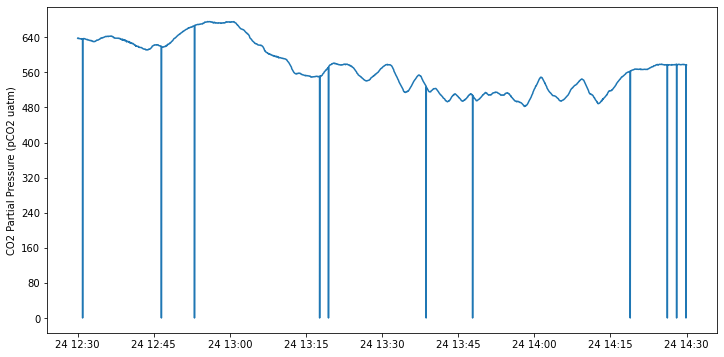

In [4]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
ax.plot(data['datetime'],data['pCO2'])
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('CO2 Partial Pressure (pCO2 uatm)')

#### Write two sentences describing if the outliers are occurring randomly or there is a pattern?
In this time range the pCO2 data goes to zero (an unreasonable number for pCO2) 11 times. This appears to be occuring randomly, although in some cases the outliers occur very close together. <br>
Looking at the data on the ONC webtool for the same time-range, these outliers are not present in any of the other sensors so it is clear that something is going wrong with the pCO2 measurement.  

# Question 3

In [69]:
d = np.array(data['pCO2']).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d)
lof10 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=100)
clf.fit_predict(d)
lof100 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=1000)
clf.fit_predict(d)
lof1000 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=2000)
clf.fit_predict(d)
lof2000 = abs(clf.negative_outlier_factor_)

In [71]:
# make array of the data removed for plotting
rem10 = d[lof10 > 2]
time10 = data['datetime'][lof10 > 2]
rem100 = d[lof100 > 2]
time100 = data['datetime'][lof100 > 2]
rem1000 = d[lof1000 > 2]
time1000 = data['datetime'][lof1000 > 2]
rem2000 = d[lof2000 > 2]
time2000 = data['datetime'][lof2000 > 2]

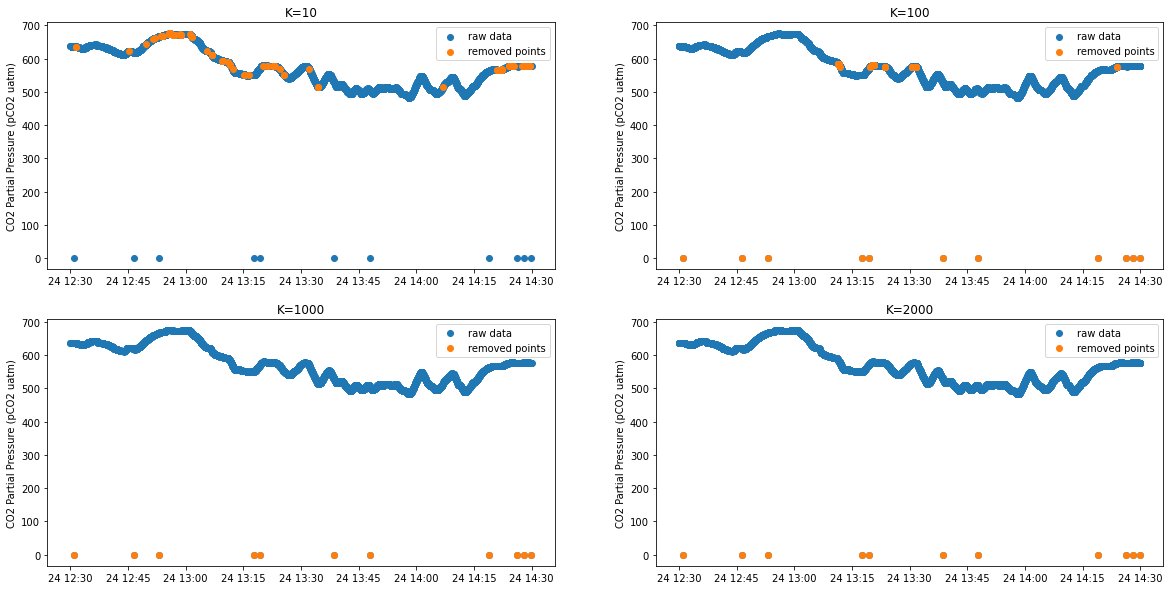

In [72]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

ax[0,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,0].scatter(time10, rem10, label='removed points')
ax[0,0].set_title('K=10')
ax[0,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,0].legend()

ax[0,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,1].scatter(time100, rem100, label='removed points')
ax[0,1].set_title('K=100')
ax[0,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,1].legend()

ax[1,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,0].scatter(time1000, rem1000, label='removed points')
ax[1,0].set_title('K=1000')
ax[1,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,0].legend()

ax[1,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,1].scatter(time2000, rem2000, label='removed points')
ax[1,1].set_title('K=2000')
ax[1,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,1].legend()

#### Comment on your plots and describe the differences between using higher or lower numbers for K.

# Question 4

In [76]:
(len(d))/8

828.875

In [91]:
# lets do 8 chunks of size 829 (with the last being 827)
chunk1 = d[0:829]
chunk2 = d[829:829*2]
chunk3 = d[829*2:829*3]
chunk4 = d[829*3:829*4]
chunk5 = d[829*4:829*5]
chunk6 = d[829*5:829*6]
chunk7 = d[829*6:829*7]
chunk8 = d[829*7:]
chunks = [chunk1, chunk2, chunk3, chunk4, chunk5, chunk6, chunk7, chunk8]

In [100]:
# for K=10
lof10 = []
for c in chunks:
    clf = LOF(n_neighbors=10)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof10 = np.append(lof10,lof)
    
rem10 = d[lof10 > 2]
time10 = data['datetime'][lof10 > 2]

In [101]:
# for K=100
lof100 = []
for c in chunks:
    clf = LOF(n_neighbors=100)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof100 = np.append(lof100,lof)
    
rem100 = d[lof100 > 2]
time100 = data['datetime'][lof100 > 2]

In [102]:
# for K=500
lof500 = []
for c in chunks:
    clf = LOF(n_neighbors=500)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof500 = np.append(lof500,lof)
    
rem500 = d[lof500 > 2]
time500 = data['datetime'][lof500 > 2]

In [103]:
# for K=800
lof800 = []
for c in chunks:
    clf = LOF(n_neighbors=800)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof800 = np.append(lof800,lof)
    
rem800 = d[lof800 > 2]
time800 = data['datetime'][lof800 > 2]

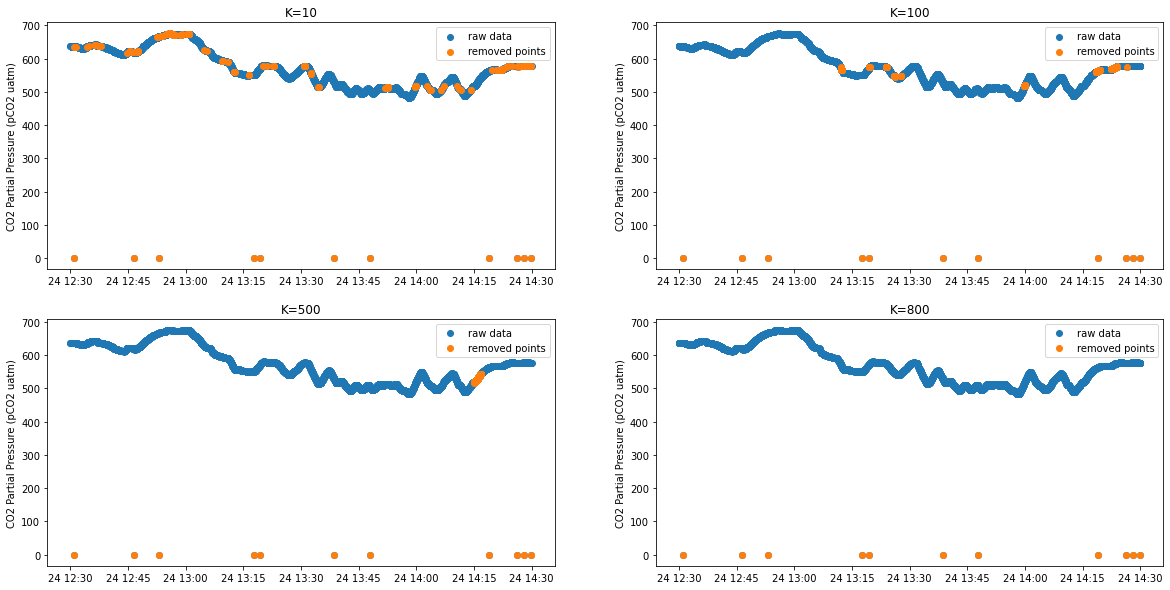

In [104]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

ax[0,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,0].scatter(time10, rem10, label='removed points')
ax[0,0].set_title('K=10')
ax[0,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,0].legend()

ax[0,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,1].scatter(time100, rem100, label='removed points')
ax[0,1].set_title('K=100')
ax[0,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,1].legend()

ax[1,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,0].scatter(time500, rem500, label='removed points')
ax[1,0].set_title('K=500')
ax[1,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,0].legend()

ax[1,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,1].scatter(time800, rem800, label='removed points')
ax[1,1].set_title('K=800')
ax[1,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,1].legend()

#### What are the main differences compared to your previous plots at step 3?

# Question 5

#### Based on your experience so far, what are the advantages and disadvantages of using LOF? 

#### Is it working well with larger or smaller data points or it doesn’t matter? Why do you think so?